# Generate Mie Spectra
This notebook is used to generate mie spectra for a power-law size distribution defined by a minimum radius cut off, maximum radius cut off and a power law index.  
The spectra will have the following shape:   
- 676 combinations of size parameters defined by 
            - min radius = 0.1 micron  
            - max radius = 2.0 to 4.5 micron  
            - power index = -1.0 to -3.5  
    For each combination of size parameters there are:
    - 32 scattering angles  
      For each scattering angle there are:
       - 240 wavelength values

pymiescatt libaray is used to generate this mie spectra.   
Function SF_SD is used since we consider a power-law size distribution.  

### Do not run this whole notebook without going through the code as one of the cells take over 8 hours to execute.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import PyMieScatt as ps
import idlsave
import os
import time
plt.rcParams.update({'font.size': 16})

## 1. Consolidate Wavelengths
Read the wavelength and refractive index values from the standard file.    
Read the wavelengths that correspond to the plume observations.    
Remove outliers that correspond to saturated filters from the plume wavelength values.   
Remove the first 97 channels that belong to lower wavelength ranges.  

We want to consolidate the mie wavelengths and mie wavelengths.   
Mie wavelengths begin at 1.1111962 micron.    
Remove plume wavelength lower than the above value.   

For the next step find mie wavelengths that are closest to each plume wavelength value.   
Store the corresponding indices.    

Then reduce the mie wavelengths and refractive indices to the relevant indices corresponding to plume wavelengths.
  

Mie Wavelengths (in micron): [1.1111962 1.1113154 1.1114346 1.1115538 1.111673  1.1117923 1.1119116
 1.1120309 1.1121503 1.1122696]
Size of mie wavelength before: 1014033

Real refractive index: [1.3124894 1.3124878 1.3124859]
Size of real refractive index: 1014033

Imaginary refractive index: [1.5059199e-06 5.0400914e-07 1.4254282e-06]
Size of imaginary refractive index: 1014033

Plume wavelength before: [0.900753 0.916924 0.933078 0.949803 0.965683]
Size of plume wavelength before: 253

Plume wavelength after: [1.11396 1.13024 1.14695 1.1637  1.17996]
Size of plume wavelength after: 240

Size of mie wavelength after: 240
Size of real refactive index after: 240
Size of imaginary refractive index after: 240


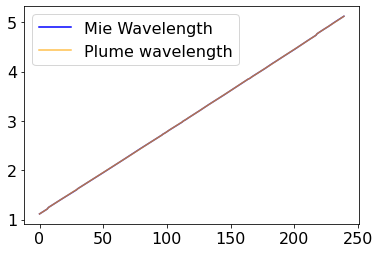

In [25]:
#Open file that contains wavelength and the refractive index values corresponding to each wavelength
#Refractive index has two parts: real and imaginary.
with open('100.txt', 'r') as f:
    lines = f.readlines()
mie_wave = np.zeros(len(lines)) #to store wavelength 
ref_real = np.zeros(len(lines)) #to store real refractive index
ref_imag = np.zeros(len(lines)) #to store imaginary refractive index
i = 0
lines = lines[1:8637]
for line in lines:
    line = line.rstrip("\n")
    mie_wave[i] = float(line.split(",")[2]) 
    ref_real[i] = float(line.split(",")[3]) 
    ref_imag[i] = float(line.split(",")[4]) 
    i += 1
mie_wave = np.array(mie_wave)
print("Mie Wavelengths (in micron):", mie_wave[:10])
print("Size of mie wavelength before:", len(mie_wave))
print("\nReal refractive index:", ref_real[:3])
print("Size of real refractive index:", len(ref_real))
print("\nImaginary refractive index:", ref_imag[:3])
print("Size of imaginary refractive index:", len(ref_imag))


#Wavelengths corresponding to plume observations
#The second column in the files refers to wavelength
with open('wavelength_vims.txt', 'r') as f:
    lines = f.readlines()
plume_wave = [float(line.split()[1]) for line in lines] 
#Remove outliers from the wavelength range where filter is saturated
spect_outlier = [118, 330]
n = 1
for i in range(len(spect_outlier)):
    del plume_wave[spect_outlier[i] - n] #n is subtracted to account for index shift after every iteration
    n = n+1 #as values are removed the index gets shifted by one each time. Update n to account for this shift

#Focus on the IR-channel and remove first 97 channels of wavelength
plume_wave = np.array(plume_wave[97:])

#Wavelenths available for mie spectra begin at 1.1111962
#Plume wavelengths before this value have to be removed
print("\nPlume wavelength before:", plume_wave[:5])
print("Size of plume wavelength before:", len(plume_wave))
difference_array = np.absolute(plume_wave - 1.1111962)
limit_index = difference_array.argmin()
plume_wave = plume_wave[limit_index:]
print("\nPlume wavelength after:", plume_wave[:5])
print("Size of plume wavelength after:", len(plume_wave))

#Now the mie wavelength and plume wavelength should match in order for our comparison to work
mie_index = []
for i in range(len(plume_wave)):
    # calculate the difference array
    difference_array = np.absolute(mie_wave - plume_wave[i])
    # find the index of minimum element from the array
    mie_index.append(difference_array.argmin())
    #print("mie_w =", mie_wave[mie_index[i]], "\n")
#np.savetxt('wavelength_index.txt', mie_index, fmt='%i')


#Save the relevant mie wavelength and refractive index correspoding to plume observations
mie_wave_rel = mie_wave[mie_index]
ref_real_rel = ref_real[mie_index]
ref_imag_rel = ref_imag[mie_index]

print("\nSize of mie wavelength after:", len(mie_wave_rel))
print("Size of real refactive index after:", len(ref_real_rel))
print("Size of imaginary refractive index after:", len(ref_imag_rel))

#Plot mie and plume wavelengths
plt.plot(mie_wave_rel, color = 'blue', label = 'Mie Wavelength')
plt.plot(plume_wave, color = 'orange', label = 'Plume wavelength', alpha = 0.7)
plt.legend()
plt.show()

#They perfectly coincide!
#save mie wavelengths
#np.savetxt('mie_wavelength.txt', mie_wave_rel)
#save plume wavelengths
#np.savetxt('plume_wavelength.txt', plume_wave)
#convert mie wavellength from micron to nanometer
mie_wave_rel_nm = mie_wave_rel*1000

## 2. Define Size parameters
Minimum radius is assumed to be 0.1 $\mu$m = 100 nm = Diamater of 200 nm    
Maximum radius range = 2.0 $\mu$m to 4.5 $\mu$m = 2000 nm to 4500 nm = Diameter of 4000 nm to 9000 nm     
Power law range = -1.0 to -3.5    
 
#### Example
For a size limit of min radius = 0.1 $\mu$m to max radius of 2.0 $\mu$m all the possible size of particles are as follows:    
[0.1, 0.2, 0.3, 0.4, ... 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]    
And the correspoding number of particle are defined using the power law index.     
For power law index of -1, number of particles will be:    
[0.1^(-1), 0.2^(-1), 0.3^(-1), 0.4^(-1)....1.9^(-1), 2.0^(-1)]  

Minimum diameter (nm): 200
Maximum diameter (nm): [4000 4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 6200 6400 6600
 6800 7000 7200 7400 7600 7800 8000 8200 8400 8600 8800 9000]
Number of maximum diameter cut off: 26
Power law index: [-1.  -1.1 -1.2 -1.3 -1.4 -1.5 -1.6 -1.7 -1.8 -1.9 -2.  -2.1 -2.2 -2.3
 -2.4 -2.5 -2.6 -2.7 -2.8 -2.9 -3.  -3.1 -3.2 -3.3 -3.4 -3.5]
Number of power law indices: 26
Number of possible combinations for max diameter values and power law indices: 676

For minimum diameter of 200 nm and max diameter of 4000 nm, 
particles of the following diameters exist:
[ 200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800
 3000 3200 3400 3600 3800 4000]
and the particles distribution for each size:
[0.01, 0.005, 0.0033333333333333335, 0.0025, 0.002, 0.0016666666666666668, 0.0014285714285714286, 0.00125, 0.0011111111111111111, 0.001, 0.0009090909090909091, 0.0008333333333333334, 0.0007692307692307692, 0.0007142857142857143, 0.0006666666666666666, 0.0006

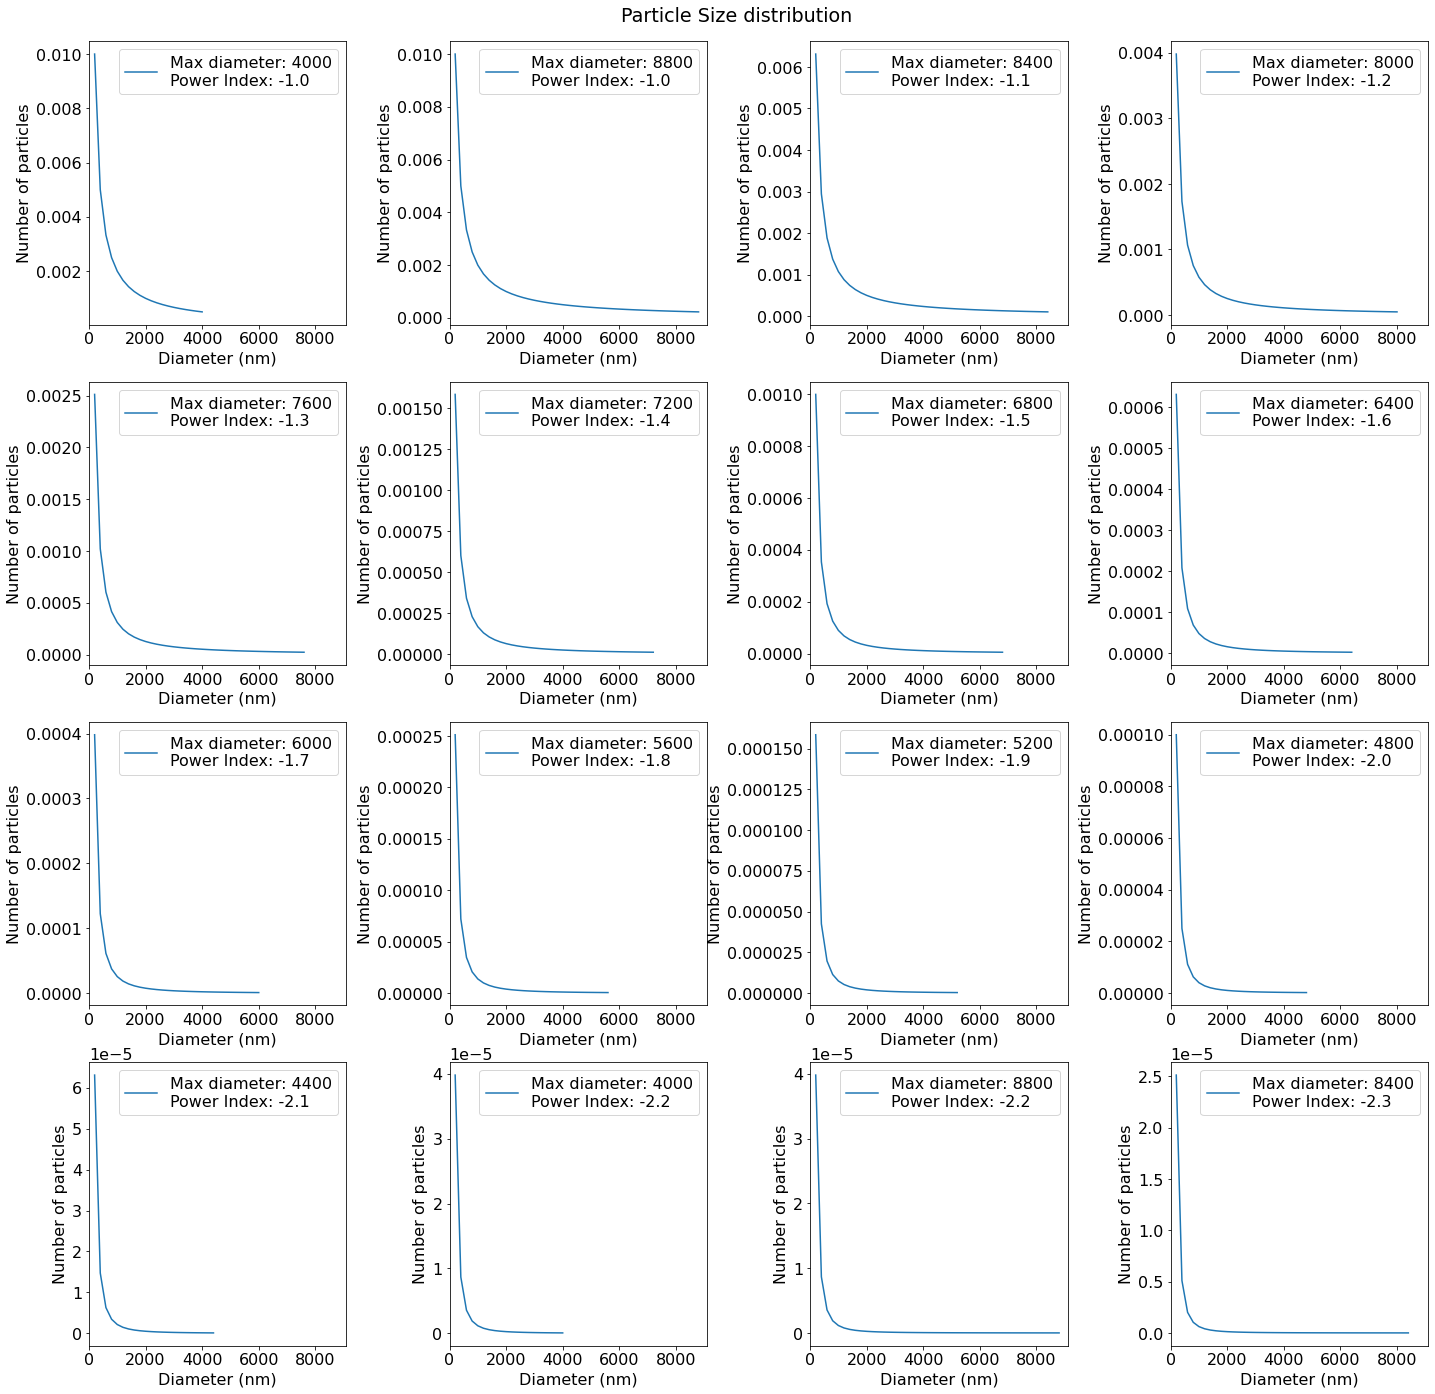

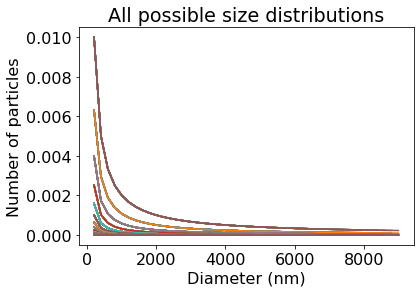

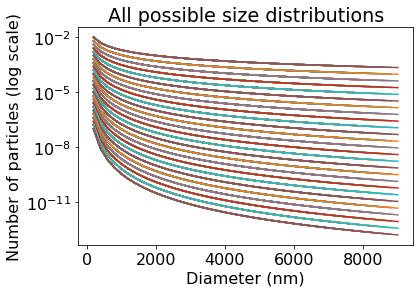

In [26]:
#Define size parameters in nm
s_min = 200 #For min radius: diameter of 0.2 micron = 200 nm corresponds to radius of 0.1 micron
s_max = np.arange(4000, 9200, 200) #Max radius varies from 0.2 micron to 4.5 micron
#print("s2", s2)
print("Minimum diameter (nm):", s_min)
print("Maximum diameter (nm):", s_max)
print("Number of maximum diameter cut off:", len(s_max))

#All possible diameters between min and max values stored in a list
diameters_range = []
for i in range(len(s_max)):
    diameters_range.append(np.arange(s_min, s_max[i] + 200, 200))
#print("dp", dp)

#power law index
pw = -1*np.arange(1.0, 3.6, 0.1) #range of power law index
print("Power law index:", pw)
print("Number of power law indices:", len(pw))
#print("pw2", pw2)
print("Number of possible combinations for max diameter values and power law indices:", len(s_max)*len(pw))


#Store number of particles for each size combination
num_particles = [] # number of particles
diameters = [] # complete set of diameters
powers = [] #power index 
#For each power law index
for power in pw:
    #for diameters in all possible diameter ranges
    for diam in diameters_range:
        num_particles.append([(d/2)**power for d in diam])
        diameters.append(diam)
        powers.append(power)
    
print(f"\nFor minimum diameter of {s_min} nm and max diameter of {s_max[0]} nm, \nparticles of the following diameters exist:\n{diameters[0]}\nand the particles distribution for each size:\n{num_particles[0]}")

#save parameters
#np.savetxt('max_radius.txt', [d[-1] for d in diameters])
#np.savetxt('power_index.txt', powers)

#plot some of the size distributions
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
fig.subplots_adjust(wspace = 0.4, hspace = 0.2)
k = 0
for i in range(4):
    for j in range(4):
        axes[i, j].plot(diameters[k], num_particles[k], label = f'Max diameter: {diameters[k][-1]}\nPower Index: {round(powers[k], 1)}')
        axes[i, j].legend()
        axes[i, j].set_xlim(0, 9100)
        axes[i, j].set_ylabel('Number of particles')
        axes[i, j].set_xlabel('Diameter (nm)')
        k += 24
plt.suptitle('Particle Size distribution', y = 0.9)
plt.show()

#Visualize all possible size distributions together
for i in range(len(num_particles)):
    plt.plot(diameters[i], num_particles[i])
plt.title("All possible size distributions")
plt.ylabel("Number of particles")
plt.xlabel("Diameter (nm)")
plt.show()

#Log plot to see all possible size distributions
for i in range(len(num_particles)):
    plt.plot(diameters[i], num_particles[i])
plt.title("All possible size distributions")
plt.ylabel("Number of particles (log scale)")
plt.xlabel("Diameter (nm)")
plt.yscale("log")
plt.show()

## 3. Find out scattering angles
We are studying three orbits of Enceladus: 279, 286, 290.  
For each orbit, a range of parameters are saved that define the observations such as 
   - orbital phase that defines the position of Enceladus in its orbit around Saturn
   - Scattering angle and phase angle that defines the angle of the observation   
   
Each image/cube corresponds to one orbital phase. The cubes/images are binned to improve the signal-to-noise ratio. The parameters also need to be binned just as the images were at the same indices. These indices are read from files Images that have been summed_S... 

- Orbital phase and Scattering angle are binned based on the indices of binned images/cubes and saved to text files.
- We alse identify the complete range of scattering angles for all orbits of Enceladus. The scattering angle varies from 18 to 24.4. 

- Mie spectra is generated for this range of scattering angles.

In [27]:
folder_name = [279, 286, 290]
file_name_images = ['100_279', '101_286', '101_290']
file_name = ['100_279_062420', '101_286_062420', '101_290_062420']
nested_scatt = []
for fold, file_img, file in zip(folder_name, file_name_images, file_name):
    
    print("Orbit:", fold)
    
    #Read index of images that have been binned together  
    indices = np.genfromtxt(f'Enceladus Plume_{fold}/images_binned_indices_{fold}.txt', dtype = int)
    print(len(indices))
        
    #Read parameters for all images in one orbit
    s = idlsave.read(f'Enceladus Plume_{fold}/encplume_filelist_geom_S{file}.sav')
    orbital_phase = s.elons - s.eperis
    print("\nOrbital Phase:", orbital_phase[:5])
    print("Length of orbital phase before binning:", len(orbital_phase))
    #Bin orbital phase as the cubes/images were binned
    binned_orbital_phase = [np.mean( orbital_phase[indices[i]] ) for i in range( len(indices) )]
    print("Length of orbital phase after binning:", len(binned_orbital_phase))
    #Save binned orbital phase
    #np.savetxt(f'Enceladus Plume_{fold}/binned_orbital_phase_{fold}.txt', binned_orbital_phase)
    
    #print("Phase Angle:", s.phase[:5])
    #print("Length of Phase angles:", len(s.phase))
    #Scattering angle
    scatt = 180 - s.phase
    print("\nScattering Angle:", scatt[:5])
    print("Length of scattering angle before binning:", len(scatt))
    #Bin scattering angle as the cubes/images were binned
    binned_scatt = [np.mean( scatt[indices[i]] ) for i in range( len(indices) )]
    print("Length of scattering angle after binning:", len(binned_scatt), "\n\n")
    #np.savetxt(f'Enceladus Plume_{fold}/binned_scattering_angle_{fold}.txt', binned_scatt)

    nested_scatt.append(binned_scatt)
    
#What is the complete range of scattering angles for all observations?
#Flatten the list of scattering angles
print("For the complete set of observations/all three orbits")
scatt_all = np.array([element for sub_list in nested_scatt for element in sub_list])
scatt_all = scatt_all.round(2)
print("Lowest scattering angle:", np.min(scatt_all))
print("Highest of scattering angle:", np.max(scatt_all))

Orbit: 279
29
--------------------------------------------------
Date: Wed Jun 24 08:19:06 2020
User: mmhedman
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 16 records of which:
 - 13 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - command [<class 'bytes'>]
 - command2 [<class 'bytes'>]
 - files [<class 'numpy.ndarray'>]
 - range [<class 'numpy.ndarray'>]
 - phase [<class 'numpy.ndarray'>]
 - lat [<class 'numpy.ndarray'>]
 - lon [<class 'numpy.ndarray'>]
 - exps [<class 'numpy.ndarray'>]
 - ets [<class 'numpy.ndarray'>]
 - s_lat [<class 'numpy.ndarray'>]
 - s_range [<class 'numpy.ndarray'>]
 - elons [<class 'numpy.ndarray'>]
 - eperis [<class 'numpy.ndarray'>]
--------------------------------------------------

Orbital Phase: [1

## 4. Generate mie spectra for the above defined size parameters
Information needed to run the mie code function SF_SD:
- Wavelength in nanometers
- Refractive index in complex form corresponding to the above wavelength: real and imaginary
- Range of diameters; For instance for a maximum radius of 2.0 micron, the range of diameters would be: [0.1, 0.2...1.8, 1.9, 2.0]
- Number of particles for each diamater defined above: For instance for a power index of -1.0 the number of particles would be: [0.1^(-1), 0.2^(-1),....1.8^(-1), 1.9^(-1), 2.0^(-1)]  
- Minimum scattering angle, in our case it is 18
- Maximum scattering angle, in our case it is 24.4. These values were defines using the above code that shows the range of scattering angles for plume observations.
- Resolution of scattering angles = 0.2 such that scatteing angle varies as [18, 18.2, 18.4...]
- The measure of scattering angle in the space = 'theta'

Returns

- theta :numpy.ndarray  
An array of the angles used in calculations. Values will be spaced according to angularResolution, and the size of the array will be (maxAngle-minAngle)/angularResolution.   
- SL :numpy.ndarray   
An array of the scattered intensity of left-polarized (perpendicular) light. Same size as the theta array.   
- SR :numpy.ndarray   
An array of the scattered intensity of right-polarized (parallel) light. Same size as the theta array.   
- SU :numpy.ndarray   
An array of the scattered intensity of unpolarized light, which is the average of SL and SR. Same size as the theta array.    

We are interested in SU as that defines our mie spectra.   

The above code is run for 676 combinations of size parameters and for each combination, there are 240 wavelengths, for each wavelength, there are 32 scattering angles.    
Reshape the array to see spectra in terms of wavelength.   

Number of the spectra: 0
Size distribution parameters:
Maximum diameter = 4000
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:0 is 32.2 seconds



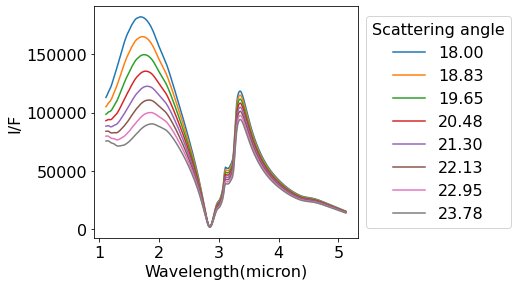

Number of the spectra: 1
Size distribution parameters:
Maximum diameter = 4200
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:1 is 34.4 seconds

Number of the spectra: 2
Size distribution parameters:
Maximum diameter = 4400
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:2 is 33.6 seconds

Number of the spectra: 3
Size distribution parameters:
Maximum diameter = 4600
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:3 is 38.3 seconds

Number of the spectra: 4
Size distribution parameters:
Maximum diameter = 4800
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:4 is 40.4 seconds



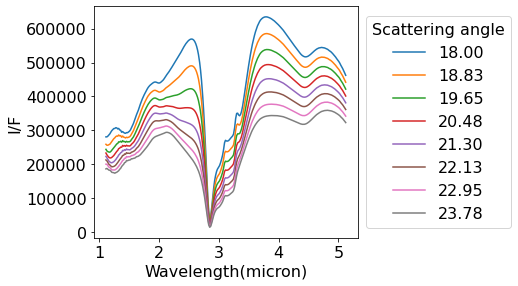

Number of the spectra: 21
Size distribution parameters:
Maximum diameter = 8200
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:21 is 70.5 seconds

Number of the spectra: 22
Size distribution parameters:
Maximum diameter = 8400
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:22 is 69.2 seconds

Number of the spectra: 23
Size distribution parameters:
Maximum diameter = 8600
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:23 is 64.1 seconds

Number of the spectra: 24
Size distribution parameters:
Maximum diameter = 8800
Power index = -1.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:24 is 66.2 s

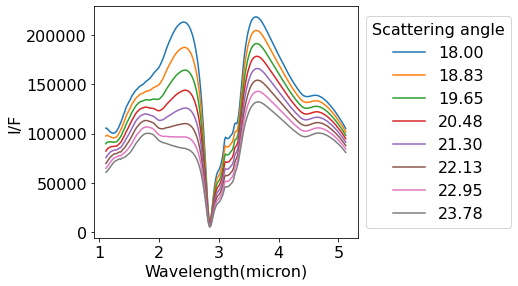

Number of the spectra: 41
Size distribution parameters:
Maximum diameter = 7000
Power index = -1.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:41 is 49.7 seconds

Number of the spectra: 42
Size distribution parameters:
Maximum diameter = 7200
Power index = -1.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:42 is 51.9 seconds

Number of the spectra: 43
Size distribution parameters:
Maximum diameter = 7400
Power index = -1.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:43 is 53.4 seconds

Number of the spectra: 44
Size distribution parameters:
Maximum diameter = 7600
Power index = -1.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:44 is 55.4 s

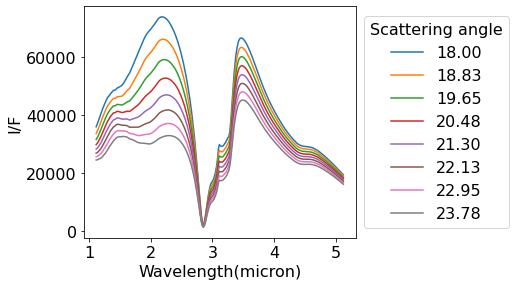

Number of the spectra: 61
Size distribution parameters:
Maximum diameter = 5800
Power index = -1.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:61 is 40.0 seconds

Number of the spectra: 62
Size distribution parameters:
Maximum diameter = 6000
Power index = -1.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:62 is 41.7 seconds

Number of the spectra: 63
Size distribution parameters:
Maximum diameter = 6200
Power index = -1.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:63 is 43.2 seconds

Number of the spectra: 64
Size distribution parameters:
Maximum diameter = 6400
Power index = -1.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:64 is 45.2 s

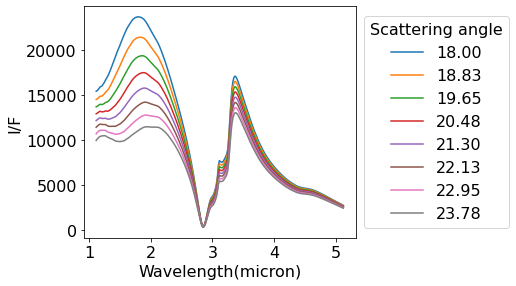

Number of the spectra: 81
Size distribution parameters:
Maximum diameter = 4600
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:81 is 30.5 seconds

Number of the spectra: 82
Size distribution parameters:
Maximum diameter = 4800
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:82 is 32.4 seconds

Number of the spectra: 83
Size distribution parameters:
Maximum diameter = 5000
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:83 is 33.9 seconds

Number of the spectra: 84
Size distribution parameters:
Maximum diameter = 5200
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:84 is 35.3 s

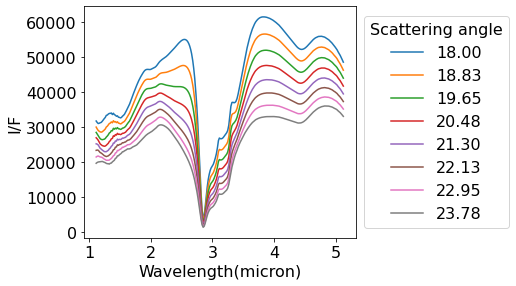

Number of the spectra: 101
Size distribution parameters:
Maximum diameter = 8600
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:101 is 64.9 seconds

Number of the spectra: 102
Size distribution parameters:
Maximum diameter = 8800
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:102 is 66.5 seconds

Number of the spectra: 103
Size distribution parameters:
Maximum diameter = 9000
Power index = -1.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:103 is 67.8 seconds

Number of the spectra: 104
Size distribution parameters:
Maximum diameter = 4000
Power index = -1.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:104 i

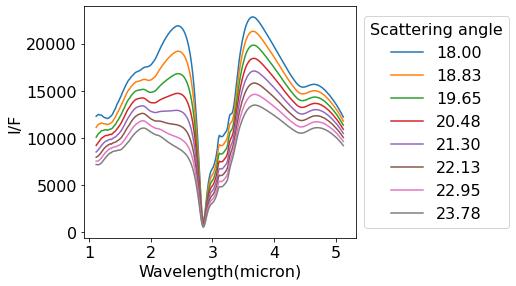

Number of the spectra: 121
Size distribution parameters:
Maximum diameter = 7400
Power index = -1.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:121 is 53.5 seconds

Number of the spectra: 122
Size distribution parameters:
Maximum diameter = 7600
Power index = -1.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:122 is 55.8 seconds

Number of the spectra: 123
Size distribution parameters:
Maximum diameter = 7800
Power index = -1.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:123 is 57.3 seconds

Number of the spectra: 124
Size distribution parameters:
Maximum diameter = 8000
Power index = -1.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:124 i

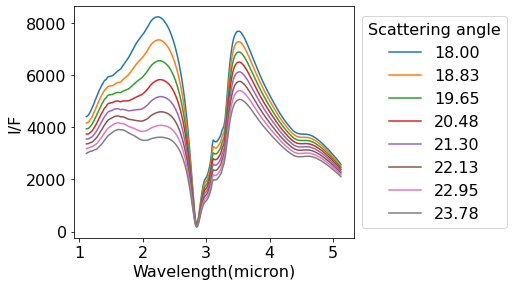

Number of the spectra: 141
Size distribution parameters:
Maximum diameter = 6200
Power index = -1.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:141 is 43.4 seconds

Number of the spectra: 142
Size distribution parameters:
Maximum diameter = 6400
Power index = -1.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:142 is 45.3 seconds

Number of the spectra: 143
Size distribution parameters:
Maximum diameter = 6600
Power index = -1.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:143 is 46.7 seconds

Number of the spectra: 144
Size distribution parameters:
Maximum diameter = 6800
Power index = -1.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:144 i

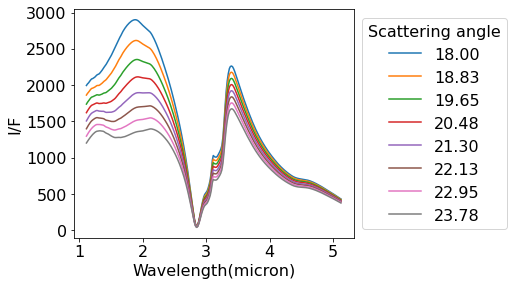

Number of the spectra: 161
Size distribution parameters:
Maximum diameter = 5000
Power index = -1.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:161 is 34.0 seconds

Number of the spectra: 162
Size distribution parameters:
Maximum diameter = 5200
Power index = -1.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:162 is 35.7 seconds

Number of the spectra: 163
Size distribution parameters:
Maximum diameter = 5400
Power index = -1.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:163 is 37.2 seconds

Number of the spectra: 164
Size distribution parameters:
Maximum diameter = 5600
Power index = -1.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:164 i

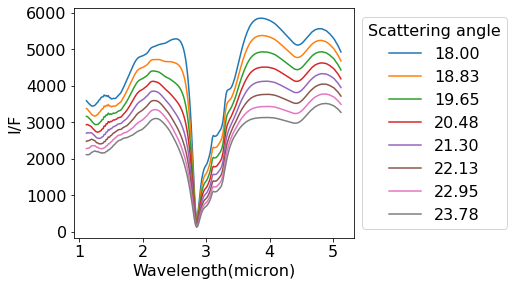

Number of the spectra: 181
Size distribution parameters:
Maximum diameter = 9000
Power index = -1.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:181 is 67.9 seconds

Number of the spectra: 182
Size distribution parameters:
Maximum diameter = 4000
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:182 is 26.4 seconds

Number of the spectra: 183
Size distribution parameters:
Maximum diameter = 4200
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:183 is 27.7 seconds

Number of the spectra: 184
Size distribution parameters:
Maximum diameter = 4400
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:184 i

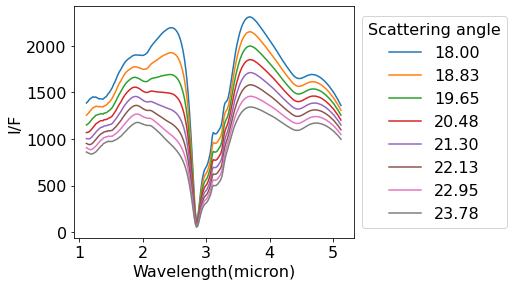

Number of the spectra: 201
Size distribution parameters:
Maximum diameter = 7800
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:201 is 57.0 seconds

Number of the spectra: 202
Size distribution parameters:
Maximum diameter = 8000
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:202 is 59.0 seconds

Number of the spectra: 203
Size distribution parameters:
Maximum diameter = 8200
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:203 is 61.0 seconds

Number of the spectra: 204
Size distribution parameters:
Maximum diameter = 8400
Power index = -1.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:204 i

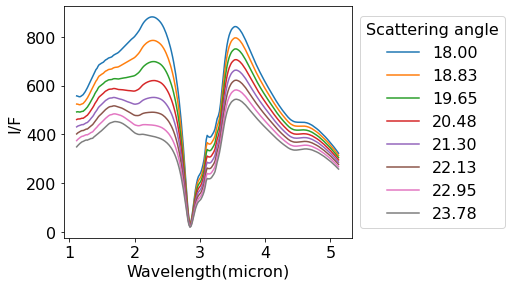

Number of the spectra: 221
Size distribution parameters:
Maximum diameter = 6600
Power index = -1.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:221 is 46.7 seconds

Number of the spectra: 222
Size distribution parameters:
Maximum diameter = 6800
Power index = -1.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:222 is 48.4 seconds

Number of the spectra: 223
Size distribution parameters:
Maximum diameter = 7000
Power index = -1.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:223 is 50.4 seconds

Number of the spectra: 224
Size distribution parameters:
Maximum diameter = 7200
Power index = -1.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:224 i

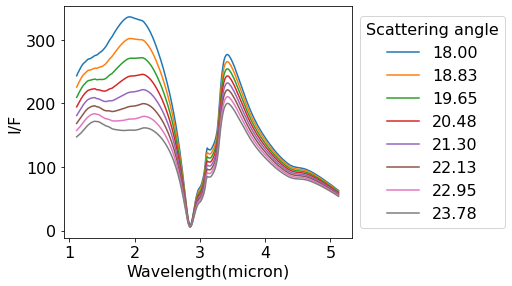

Number of the spectra: 241
Size distribution parameters:
Maximum diameter = 5400
Power index = -1.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:241 is 37.0 seconds

Number of the spectra: 242
Size distribution parameters:
Maximum diameter = 5600
Power index = -1.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:242 is 38.6 seconds

Number of the spectra: 243
Size distribution parameters:
Maximum diameter = 5800
Power index = -1.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:243 is 40.3 seconds

Number of the spectra: 244
Size distribution parameters:
Maximum diameter = 6000
Power index = -1.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:244 i

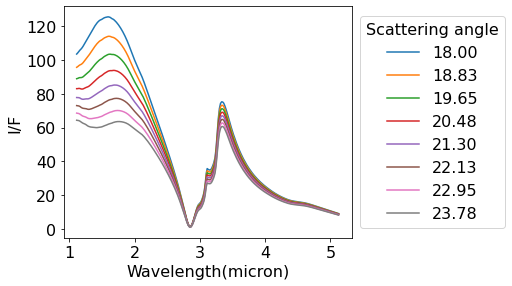

Number of the spectra: 261
Size distribution parameters:
Maximum diameter = 4200
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:261 is 27.7 seconds

Number of the spectra: 262
Size distribution parameters:
Maximum diameter = 4400
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:262 is 29.2 seconds

Number of the spectra: 263
Size distribution parameters:
Maximum diameter = 4600
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:263 is 30.8 seconds

Number of the spectra: 264
Size distribution parameters:
Maximum diameter = 4800
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:264 i

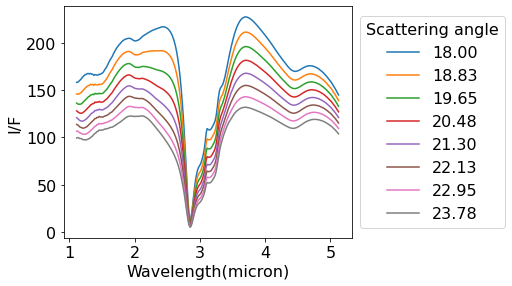

Number of the spectra: 281
Size distribution parameters:
Maximum diameter = 8200
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:281 is 60.3 seconds

Number of the spectra: 282
Size distribution parameters:
Maximum diameter = 8400
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:282 is 62.2 seconds

Number of the spectra: 283
Size distribution parameters:
Maximum diameter = 8600
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:283 is 64.6 seconds

Number of the spectra: 284
Size distribution parameters:
Maximum diameter = 8800
Power index = -2.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:284 i

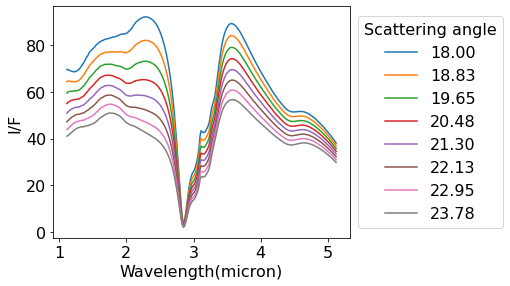

Number of the spectra: 301
Size distribution parameters:
Maximum diameter = 7000
Power index = -2.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:301 is 50.3 seconds

Number of the spectra: 302
Size distribution parameters:
Maximum diameter = 7200
Power index = -2.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:302 is 51.5 seconds

Number of the spectra: 303
Size distribution parameters:
Maximum diameter = 7400
Power index = -2.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:303 is 53.3 seconds

Number of the spectra: 304
Size distribution parameters:
Maximum diameter = 7600
Power index = -2.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:304 i

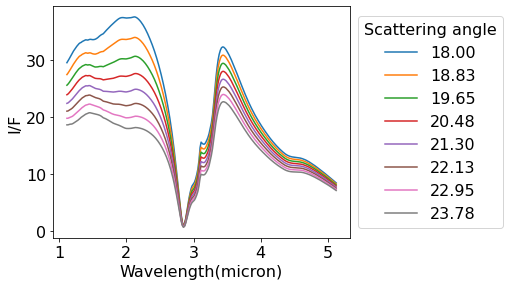

Number of the spectra: 321
Size distribution parameters:
Maximum diameter = 5800
Power index = -2.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:321 is 41.7 seconds

Number of the spectra: 322
Size distribution parameters:
Maximum diameter = 6000
Power index = -2.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:322 is 41.8 seconds

Number of the spectra: 323
Size distribution parameters:
Maximum diameter = 6200
Power index = -2.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:323 is 43.3 seconds

Number of the spectra: 324
Size distribution parameters:
Maximum diameter = 6400
Power index = -2.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:324 i

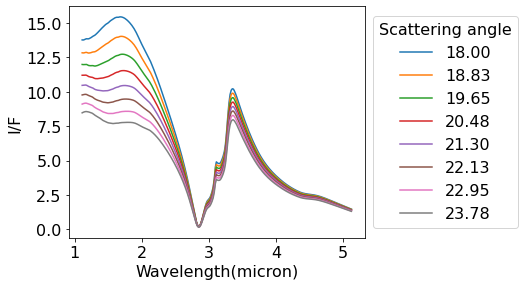

Number of the spectra: 341
Size distribution parameters:
Maximum diameter = 4600
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:341 is 30.8 seconds

Number of the spectra: 342
Size distribution parameters:
Maximum diameter = 4800
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:342 is 32.4 seconds

Number of the spectra: 343
Size distribution parameters:
Maximum diameter = 5000
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:343 is 33.8 seconds

Number of the spectra: 344
Size distribution parameters:
Maximum diameter = 5200
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:344 i

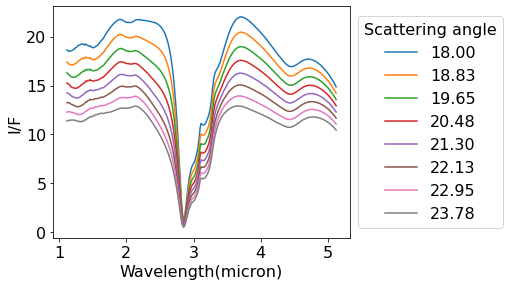

Number of the spectra: 361
Size distribution parameters:
Maximum diameter = 8600
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:361 is 64.5 seconds

Number of the spectra: 362
Size distribution parameters:
Maximum diameter = 8800
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:362 is 66.3 seconds

Number of the spectra: 363
Size distribution parameters:
Maximum diameter = 9000
Power index = -2.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:363 is 67.6 seconds

Number of the spectra: 364
Size distribution parameters:
Maximum diameter = 4000
Power index = -2.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:364 i

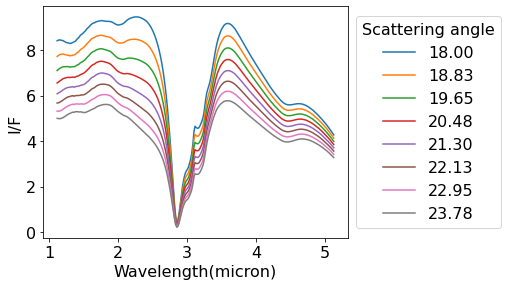

Number of the spectra: 381
Size distribution parameters:
Maximum diameter = 7400
Power index = -2.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:381 is 53.7 seconds

Number of the spectra: 382
Size distribution parameters:
Maximum diameter = 7600
Power index = -2.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:382 is 55.1 seconds

Number of the spectra: 383
Size distribution parameters:
Maximum diameter = 7800
Power index = -2.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:383 is 57.1 seconds

Number of the spectra: 384
Size distribution parameters:
Maximum diameter = 8000
Power index = -2.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:384 i

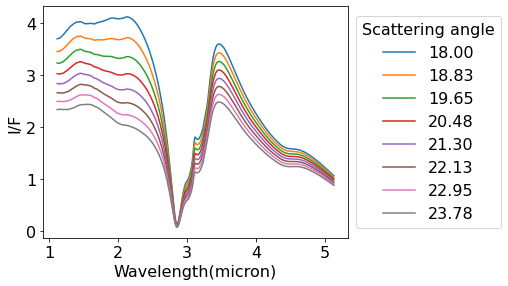

Number of the spectra: 401
Size distribution parameters:
Maximum diameter = 6200
Power index = -2.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:401 is 43.6 seconds

Number of the spectra: 402
Size distribution parameters:
Maximum diameter = 6400
Power index = -2.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:402 is 45.0 seconds

Number of the spectra: 403
Size distribution parameters:
Maximum diameter = 6600
Power index = -2.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:403 is 46.6 seconds

Number of the spectra: 404
Size distribution parameters:
Maximum diameter = 6800
Power index = -2.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:404 i

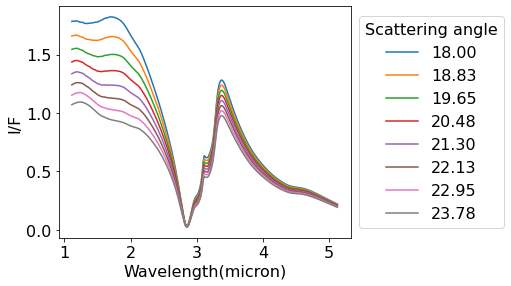

Number of the spectra: 421
Size distribution parameters:
Maximum diameter = 5000
Power index = -2.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:421 is 34.0 seconds

Number of the spectra: 422
Size distribution parameters:
Maximum diameter = 5200
Power index = -2.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:422 is 35.7 seconds

Number of the spectra: 423
Size distribution parameters:
Maximum diameter = 5400
Power index = -2.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:423 is 37.2 seconds

Number of the spectra: 424
Size distribution parameters:
Maximum diameter = 5600
Power index = -2.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:424 i

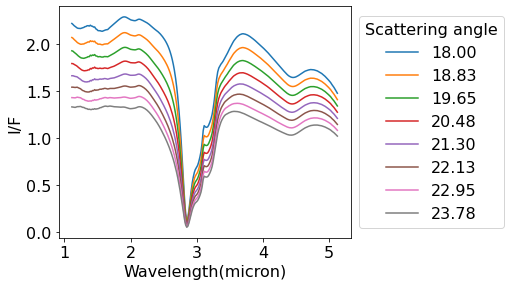

Number of the spectra: 441
Size distribution parameters:
Maximum diameter = 9000
Power index = -2.6
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:441 is 68.0 seconds

Number of the spectra: 442
Size distribution parameters:
Maximum diameter = 4000
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:442 is 26.3 seconds

Number of the spectra: 443
Size distribution parameters:
Maximum diameter = 4200
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:443 is 27.9 seconds

Number of the spectra: 444
Size distribution parameters:
Maximum diameter = 4400
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:444 i

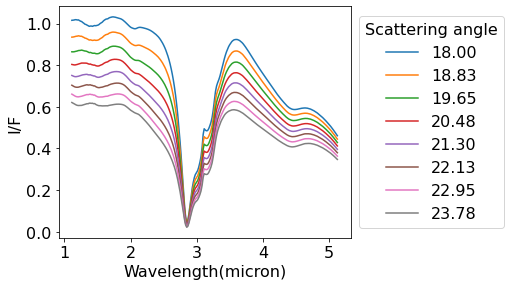

Number of the spectra: 461
Size distribution parameters:
Maximum diameter = 7800
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:461 is 57.0 seconds

Number of the spectra: 462
Size distribution parameters:
Maximum diameter = 8000
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:462 is 58.7 seconds

Number of the spectra: 463
Size distribution parameters:
Maximum diameter = 8200
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:463 is 60.2 seconds

Number of the spectra: 464
Size distribution parameters:
Maximum diameter = 8400
Power index = -2.7
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:464 i

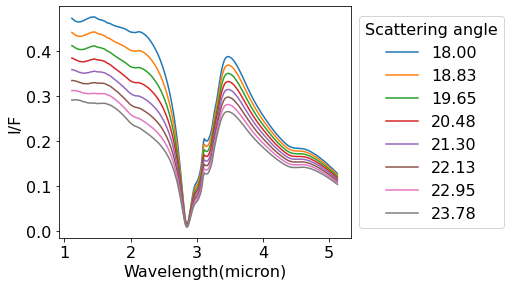

Number of the spectra: 481
Size distribution parameters:
Maximum diameter = 6600
Power index = -2.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:481 is 47.3 seconds

Number of the spectra: 482
Size distribution parameters:
Maximum diameter = 6800
Power index = -2.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:482 is 48.7 seconds

Number of the spectra: 483
Size distribution parameters:
Maximum diameter = 7000
Power index = -2.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:483 is 50.3 seconds

Number of the spectra: 484
Size distribution parameters:
Maximum diameter = 7200
Power index = -2.8
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:484 i

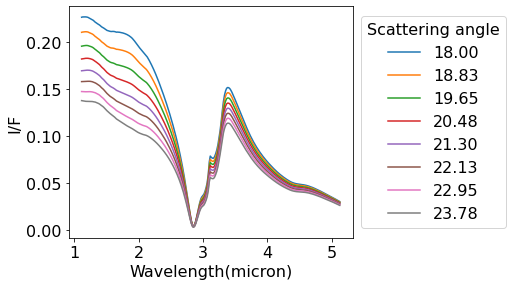

Number of the spectra: 501
Size distribution parameters:
Maximum diameter = 5400
Power index = -2.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:501 is 36.9 seconds

Number of the spectra: 502
Size distribution parameters:
Maximum diameter = 5600
Power index = -2.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:502 is 38.9 seconds

Number of the spectra: 503
Size distribution parameters:
Maximum diameter = 5800
Power index = -2.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:503 is 40.3 seconds

Number of the spectra: 504
Size distribution parameters:
Maximum diameter = 6000
Power index = -2.9
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:504 i

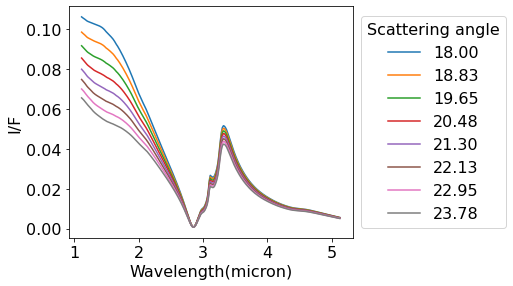

Number of the spectra: 521
Size distribution parameters:
Maximum diameter = 4200
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:521 is 27.6 seconds

Number of the spectra: 522
Size distribution parameters:
Maximum diameter = 4400
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:522 is 29.3 seconds

Number of the spectra: 523
Size distribution parameters:
Maximum diameter = 4600
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:523 is 31.1 seconds

Number of the spectra: 524
Size distribution parameters:
Maximum diameter = 4800
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:524 i

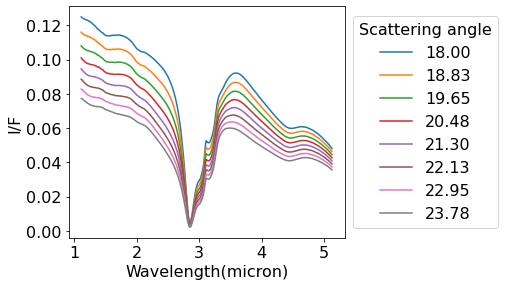

Number of the spectra: 541
Size distribution parameters:
Maximum diameter = 8200
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:541 is 60.2 seconds

Number of the spectra: 542
Size distribution parameters:
Maximum diameter = 8400
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:542 is 62.6 seconds

Number of the spectra: 543
Size distribution parameters:
Maximum diameter = 8600
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:543 is 63.8 seconds

Number of the spectra: 544
Size distribution parameters:
Maximum diameter = 8800
Power index = -3.0
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:544 i

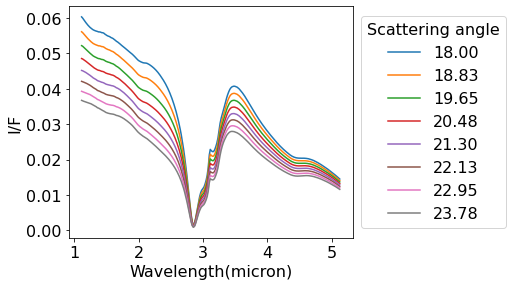

Number of the spectra: 561
Size distribution parameters:
Maximum diameter = 7000
Power index = -3.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:561 is 50.0 seconds

Number of the spectra: 562
Size distribution parameters:
Maximum diameter = 7200
Power index = -3.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:562 is 52.1 seconds

Number of the spectra: 563
Size distribution parameters:
Maximum diameter = 7400
Power index = -3.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:563 is 53.6 seconds

Number of the spectra: 564
Size distribution parameters:
Maximum diameter = 7600
Power index = -3.1
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:564 i

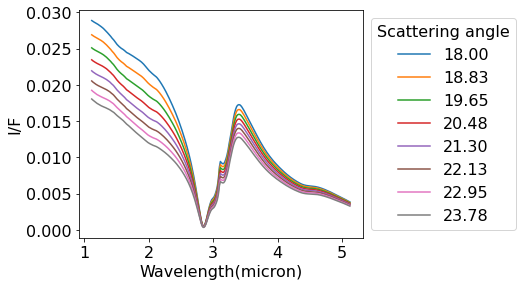

Number of the spectra: 581
Size distribution parameters:
Maximum diameter = 5800
Power index = -3.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:581 is 40.4 seconds

Number of the spectra: 582
Size distribution parameters:
Maximum diameter = 6000
Power index = -3.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:582 is 42.1 seconds

Number of the spectra: 583
Size distribution parameters:
Maximum diameter = 6200
Power index = -3.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:583 is 43.5 seconds

Number of the spectra: 584
Size distribution parameters:
Maximum diameter = 6400
Power index = -3.2
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:584 i

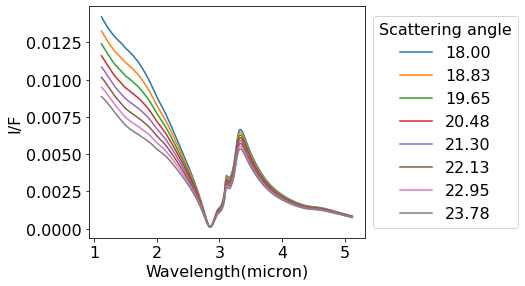

Number of the spectra: 601
Size distribution parameters:
Maximum diameter = 4600
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:601 is 30.9 seconds

Number of the spectra: 602
Size distribution parameters:
Maximum diameter = 4800
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:602 is 32.5 seconds

Number of the spectra: 603
Size distribution parameters:
Maximum diameter = 5000
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:603 is 33.9 seconds

Number of the spectra: 604
Size distribution parameters:
Maximum diameter = 5200
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:604 i

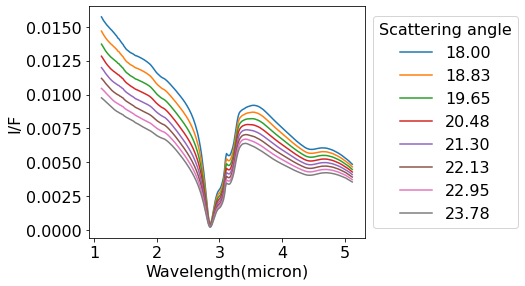

Number of the spectra: 621
Size distribution parameters:
Maximum diameter = 8600
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:621 is 64.7 seconds

Number of the spectra: 622
Size distribution parameters:
Maximum diameter = 8800
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:622 is 66.3 seconds

Number of the spectra: 623
Size distribution parameters:
Maximum diameter = 9000
Power index = -3.3
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:623 is 68.4 seconds

Number of the spectra: 624
Size distribution parameters:
Maximum diameter = 4000
Power index = -3.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:624 i

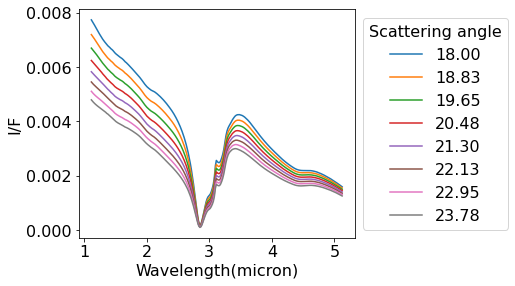

Number of the spectra: 641
Size distribution parameters:
Maximum diameter = 7400
Power index = -3.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:641 is 53.8 seconds

Number of the spectra: 642
Size distribution parameters:
Maximum diameter = 7600
Power index = -3.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:642 is 56.8 seconds

Number of the spectra: 643
Size distribution parameters:
Maximum diameter = 7800
Power index = -3.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:643 is 57.3 seconds

Number of the spectra: 644
Size distribution parameters:
Maximum diameter = 8000
Power index = -3.4
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:644 i

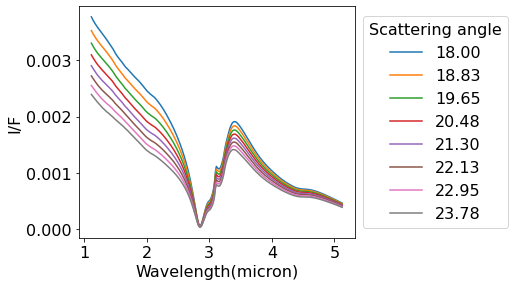

Number of the spectra: 661
Size distribution parameters:
Maximum diameter = 6200
Power index = -3.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:661 is 43.6 seconds

Number of the spectra: 662
Size distribution parameters:
Maximum diameter = 6400
Power index = -3.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:662 is 45.4 seconds

Number of the spectra: 663
Size distribution parameters:
Maximum diameter = 6600
Power index = -3.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:663 is 46.9 seconds

Number of the spectra: 664
Size distribution parameters:
Maximum diameter = 6800
Power index = -3.5
Shape of mie scattering spectra: (240, 32)
Shape of mie scattering spectra after transpose: (32, 240)
Time lapsed for spectra number:664 i

In [28]:
#Calculating model spectra for 546 variations of the 3 paramater defined above
su_dp = []
begin = time.time()
#Loop for combinations of 676 size parameters
for k in range(len(num_particles)):
    su = []
    print("Number of the spectra:", k)
    print(f"Size distribution parameters:\nMaximum diameter = { round(diameters[k][-1], 1) }\nPower index = { round(powers[k], 1) }")
    #sc=len(dpf[k])-1
    start = time.time()
    #Loop for mie wavelengths
    for i in range(len(mie_wave_rel_nm)):
        wave_begin = time.time()
        m = complex(ref_real_rel[i], ref_imag_rel[i])
        theta1, SL, SR, SU = ps.SF_SD(m, mie_wave_rel_nm[i], diameters[k], num_particles[k],
                            minAngle = (18), maxAngle = (24.4),
                            angularResolution = 0.2, space = 'theta')
        SU2 = (np.asarray(SU) * mie_wave_rel_nm[i]**2) / (4 * math.pi**2) #length of 32
        #print(len(SU2))
        wave_end = time.time()
        #if i%10 == 0:
            #print(f"Time lapsed for wavelength = {round(mie_wave_rel[i], 3)} micron is {round((wave_end - wave_begin), 1)} seconds")
        su.append(SU2)
    #su will have length of 240 for the 240 wavelengths
    end = time.time()
    print("Shape of mie scattering spectra:", np.array(su).shape)
    su_t = np.array(su).T
    print("Shape of mie scattering spectra after transpose:", su_t.shape)
    print(f"Time lapsed for spectra number:{k} is {round((end - start), 1)} seconds\n")
    
    if k%20 == 0:
        fig = plt.figure(1)
        ax = plt.gca()
        for j in range(0, len(su_t), 4):
            plt.plot(mie_wave_rel, su_t[j], label='%0.2f' % (theta1[j]*180/math.pi))
        fig.set_size_inches(w=6,h=4)
        plt.tight_layout()
        plt.xlabel("Wavelength(micron)")
        plt.ylabel("I/F")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Scattering angle')
        plt.show()
    
    su_dp.append(np.array(su).T)
    
print("Time lapsed for all spectra (hours):", round((end - begin)/3600, 1))

- Save mie spectra and mie scattering angle to text files.

In [29]:
su_dp = np.array(su_dp).reshape(len(su_dp), -1)
np.savetxt('mie_spectra_100.txt', su_dp)

In [8]:
#np.savetxt('mie_scatt_angle.txt', np.array(theta1)*180/math.pi)

## List of files created in this notebook
- File wavelength_index.txt stores the index at which the wavelength for which refractive indices (used to generate mie spectra) are defined coincides with the wavelength corresponding to plume observations.
- File mie_wavelength.txt contains the wavelength for mie spectra
- File plume_wavelength.txt contains the wavelength for plume spectra
- File max_radius.txt saves the maximum radius for each of the 676 combinations of size parameters
- File power_index.txt saves the power law index for each of the 676 combinations of size parameters
- Folder Enceladus Plume_279    
     - File binned_orbital_phase_279.txt that stores binned orbital phase values for orbit no. 279    
     - File binned_scattering_angle_279.txt that stores binned scattering angle values for orbit no. 279   
- Folder Enceladus Plume_286    
     - File binned_orbital_phase_286.txt that stores binned orbital phase values for orbit no. 286
     - File binned_scattering_angle_286.txt that stores binned scattering angle values for orbit no. 286
- Folder Enceladus Plume_290    
     - File binned_orbital_phase_290.txt that stores binned orbital phase values for orbit no. 290
     - File binned_scattering_angle_290.txt that stores binned scattering angle values for orbit no. 290
- File mie_spectra.txt stores the spectra generated using mie scattering theory. The spectra saved has the following shape: 
     - 676 combination of size parameters
     - 7680 = 32 * 240 where there are 32 scattering angles and 240 wavelengths. This order is maintained when the date is saved in txt format. Remember that when reading the file.
- File mie_scatt_angle.txt save the 32 scattering angles for which mie spectra is generated.